In [15]:
import numpy as np
import sys 
sys.path.append(r'../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import torch
import sys 
sys.path.append(r'../../../HLsearch/')
import HLsearch as HL

In [16]:
import time

def generate_data(func, time, init_values):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='RK45',rtol=1e-10,atol=1e-10)
    return sol.y.T, np.array([func(0,sol.y.T[i,:]) for i in range(sol.y.T.shape[0])],dtype=np.float64)

def pendulum(t,x):
    return x[1],-9.81*np.sin(x[0])

In [37]:
#Saving Directory
rootdir = "../Single Pendulum/"

num_sample = 100
create_data = False
training = False

a = 1
b = 1
noiselevel = a*10**(-b)

In [38]:
if(create_data):
    X, Xdot = [], []
    for i in range(num_sample):
        t = np.arange(0,5,0.01)

        theta = np.random.uniform(-np.pi, np.pi)
        thetadot = np.random.uniform(-2.1,2.1)
        cond = 0.5*thetadot**2 - np.cos(theta)
        #checking condition so that it does not go full loop
        while(cond>0.99):
            theta = np.random.uniform(-np.pi, np.pi)
            thetadot = np.random.uniform(-2.1,2.1)
            cond = 0.5*thetadot**2 - np.cos(theta)
        
        y_0 = np.array([theta, thetadot])
        x,xdot = generate_data(pendulum, t, y_0)
        X.append(x)
        Xdot.append(xdot)
    X = np.vstack(X)
    Xdot = np.vstack(Xdot)
else:
    X = np.load(rootdir + "Data/Passive/X.npy")
    Xdot = np.load(rootdir + "Data/Passive/Xdot.npy")

In [39]:
states_dim = 2
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x0_t)
states derivatives are:  (x0_t, x0_tt)


In [40]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [41]:
#identifier = "no"
identifier = str(a) + "e-0" + str(b)
if(training==False):
    with open(rootdir + "Data/Passive/lagrangian_" + identifier + "_noise.txt") as f:
        L = f.readline()
        print(L)
        expr = L.split(" +")
        device = "cuda:0"
        xi_L = torch.ones(len(expr),device=device)
        mask = torch.ones(len(expr),device=device)
        

-0.019*x0**2 + 0.085*x0_t**2 - 0.129*x0_t*sin(x0) + 0.551*sin(x0)**2 + 1.54*cos(x0) - 0.265


In [42]:
#obtaining equations of motions
x0 = dynamicsymbols(states[0])
x0_t = dynamicsymbols(states[0],1)
L = eval(str(L))
LM = LagrangesMethod(L, [x0])
LM.form_lagranges_equations()
eom = LM.rhs()[1]

#convert to string
eom = str(eom).replace('(t)','')

def predictedpendulum(t,x):
    from numpy import sin, cos
    x0 = x[0]
    x0_t = x[1]
    return x0_t,eval(eom)

In [43]:
## Training Results ##
import matplotlib.pyplot as plt

#forward
t = np.arange(0,5,0.01)

idx = 0
y_0 = X[idx,:]

X, Xdot = generate_data(pendulum, t, y_0)

q_tt_true_wn = (Xdot[:,states_dim//2:].T).copy()
q_t_true_wn = (Xdot[:,:states_dim//2].T).copy()
q_true_wn = (X[:,:states_dim//2].T).copy()

#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

q_tt_true = Xdot[:,states_dim//2:].T
q_t_true = Xdot[:,:states_dim//2].T
q_true = X[:,:states_dim//2].T

#ours
Xpred,Xdotpred = generate_data(predictedpendulum, t, y_0)

q_tt_pred = Xdotpred[:,states_dim//2:].T
q_t_pred = Xdotpred[:,:states_dim//2].T
q_pred = Xpred[:,:states_dim//2].T

In [44]:
## Validation Results ##
ttest = np.arange(5,10,0.01)
y_0 = np.array([q_true_wn[0,-1], q_t_true_wn[0,-1]])
Xtest,Xdottest = generate_data(pendulum, ttest, y_0)

y_0 = np.array([q_pred[0,-1], q_t_pred[0,-1]])
Xtestpred,Xdottestpred = generate_data(predictedpendulum, ttest, y_0)

In [45]:
# Concatenante training and test data
t = np.concatenate((t, ttest))
q_tt_true = np.concatenate((q_tt_true, Xdottest[:,states_dim//2:].T), axis=1)
q_t_true = np.concatenate((q_t_true, Xtest[:,states_dim//2:].T), axis=1)
q_true = np.concatenate((q_true,Xtest[:,:states_dim//2].T), axis=1)

q_tt_pred = np.concatenate((q_tt_pred,Xdottestpred[:,states_dim//2:].T), axis=1)
q_t_pred = np.concatenate((q_t_pred, Xtestpred[:,states_dim//2:].T), axis=1)
q_pred = np.concatenate((q_pred,Xtestpred[:,:states_dim//2].T), axis=1)

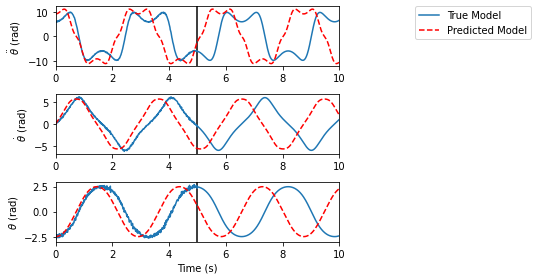

In [46]:
fig, ax = plt.subplots(3,1,figsize=(5,4))

ax[0].plot(t, q_tt_true[0,:], label='True Model')
ax[0].plot(t, q_tt_pred[0,:], 'r--',label='Predicted Model')
ax[0].set_ylabel('$\ddot{\\theta}$ (rad)')
ax[0].vlines(5,0,1,transform=ax[0].get_xaxis_transform(),colors='k')
ax[0].set_xlim([0,10])

ax[1].plot(t, q_t_true[0,:], label='True Model')
ax[1].plot(t, q_t_pred[0,:], 'r--',label='Predicted Model')
ax[1].set_ylabel('$\dot{\\theta}$ (rad)')
ax[1].vlines(5,0,1,transform=ax[1].get_xaxis_transform(),colors='k')
ax[1].set_xlim([0,10])

ax[2].plot(t, q_true[0,:], label='True Model')
ax[2].plot(t, q_pred[0,:], 'r--',label='Predicted Model')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('$\\theta$ (rad)')
ax[2].vlines(5,0,1,transform=ax[2].get_xaxis_transform(),colors='k')
ax[2].set_xlim([0,10])

Line, Label = ax[0].get_legend_handles_labels()
fig.legend(Line, Label, loc='upper right', bbox_to_anchor=(1.5, 0.98))

fig.tight_layout()
fig.savefig(rootdir + "Images/training_" + identifier+ "_noise.png", bbox_inches='tight',dpi=400)
